In [25]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
%run ./common_init.ipynb

In [27]:
%run ./learning_init.ipynb

In [28]:
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
import pathlib
import pickle

In [29]:
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [30]:
from sklearn.model_selection import ParameterGrid, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, log_loss, roc_auc_score, balanced_accuracy_score, precision_score, classification_report, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [31]:
# Where to save the figures

CHAPTER_ID = "gradient_boosting"
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output/'eda')

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

In [32]:
with open(pathlib.Path(Config.get("df_store"), "X_train.pd.pkl"), "rb") as f:
    kdd98_learn_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_train.pd.pkl"), "rb") as f:
    kdd98_learn_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test.pd.pkl"), "rb") as f:
    kdd98_test_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_test.pd.pkl"), "rb") as f:
    kdd98_test_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_train_all_relevant.pd.pkl"), "rb") as f:
    kdd98_learn_feat_all_relevant = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test_all_relevant.pd.pkl"), "rb") as f:
    kdd98_test_feat_all_relevant = pickle.load(f)
    
# Extracting the data and resetting target to [-1, 1]
X_train = kdd98_learn_feat.values
X_train_all_relevant = kdd98_learn_feat_all_relevant.values
y_train = kdd98_learn_targets.loc[:,"TARGET_B"].astype("int64").values
X_test = kdd98_test_feat.values
X_test_all_relevant = kdd98_test_feat_all_relevant.values
y_test = kdd98_test_targets.loc[:,"TARGET_B"].astype("int64").values

In [33]:
class_weight = len(y_train[y_train == 0])/sum(y_train)

#  XGBoost

All fits are run with the dataset filtered down to all-relevant features with Boruta.

Parameters:

- J (tree size): max_depth. Hastie recommends 6, stumps (2) can be very good (only first-order), 4 < J <8
- M (number of trees): n_estimators
- $\nu$ (shrinkage): learning_rate: Small $\nu$ need large M
- $\eta$ (subsampling): colsample_by_tree, set to 1/2. This is effectively stochastic gradient descent
-> Set $\nu$ small and terminate by early stopping

early_stopping_rounds (int) – Activates early stopping. Validation error needs to decrease at least every <early_stopping_rounds> round(s) to continue training. Requires at least one item in evals. If there’s more than one, will use the last. Returns the model from the last iteration (not the best one). If early stopping occurs, the model will have three additional fields: bst.best_score, bst.best_iteration and bst.best_ntree_limit

## Baseline

In [ ]:
xgb_base = XGBClassifier(scale=class_weight,
                         seed=Config.get("random_seed"))
xgb_base.fit(X_train_all_relevant, y_train)

In [ ]:
y_predicted = xgb_base.predict(X_test_all_relevant)

In [ ]:
print(classification_report(y_test,y_predicted))

## Gridsearch with oversampled minority class
This approach uses an oversampled minority class

### Balancing target
Run either one of the below cells to get a sample with balanced target classes

In [ ]:
smt = SMOTETomek(sampling_strategy='minority',
                 random_state=Config.get("random_seed"))
X_resampled, y_resampled = smt.fit_resample(X_train_all_relevant, y_train)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

In [10]:
ovs = RandomOverSampler(sampling_strategy="minority", random_state=Config.get("random_seed"))
X_resampled, y_resampled = ovs.fit_resample(X_train_all_relevant, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 72455), (1, 72455)]


In [ ]:
smt = SMOTETomek(sampling_strategy='minority',
                 random_state=Config.get("random_seed"))
X_resampled, y_resampled = smt.fit_resample(X_train, train_target)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

### Setting up gridsearch

In [11]:
# We use stochastic gradient boosting (subsample < 1),
# a maximum depth of 2 or 3,
# a very small learning rate combined with early stopping if there's no improvement
param_grid = {
    "learning_rate": [0.01, 0.1, 0.3],
    "colsample_bytree": [0.1, 0.25, 0.5]
}

# Scorer, we choose ROC and set weighted average according to class frequencies
roc = make_scorer(roc_auc_score)

xgb_oversampling = XGBClassifier(
    booster="gbtree",
    n_estimators=2000,
    colsample_by_tree=0.5,
    learning_rate=0.1,
    subsample=0.5,
    max_depth=6,
    seed=Config.get("random_seed"),
    verbose=2)

In [21]:
gs_xgboost_oversampling = GridSearchCV(
    xgb_oversampling,
    param_grid,
    scoring={
        "ROC_AUC": roc,
        "logloss": "neg_log_loss"
    },
    n_jobs=-1,
    refit="logloss",
    cv=5,
    verbose=3)

We pass an eval set. The last (X_test) is used for early stopping. When the eval metric does no longer decrease, training is stopped

### Fitting and results

In [23]:
gs_xgboost_oversampling.fit(
    X_resampled,
    y_resampled,
    early_stopping_rounds=10,
    eval_metric="logloss",
    eval_set=[(X_resampled, y_resampled), (X_test_all_relevant, y_test)])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 86.8min finished


[0]	validation_0-logloss:0.684539	validation_1-logloss:0.685361
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.67218	validation_1-logloss:0.673506
[2]	validation_0-logloss:0.661448	validation_1-logloss:0.663068
[3]	validation_0-logloss:0.656193	validation_1-logloss:0.65886
[4]	validation_0-logloss:0.648355	validation_1-logloss:0.651013
[5]	validation_0-logloss:0.641877	validation_1-logloss:0.644138
[6]	validation_0-logloss:0.63383	validation_1-logloss:0.636903
[7]	validation_0-logloss:0.627998	validation_1-logloss:0.631506
[8]	validation_0-logloss:0.622877	validation_1-logloss:0.627298
[9]	validation_0-logloss:0.617161	validation_1-logloss:0.621986
[10]	validation_0-logloss:0.612949	validation_1-logloss:0.617878
[11]	validation_0-logloss:0.609909	validation_1-logloss:0.614971
[12]	validation_0-logloss:0.604406	validation_1-logloss:0.610263
[13

[273]	validation_0-logloss:0.308339	validation_1-logloss:0.371558
[274]	validation_0-logloss:0.307834	validation_1-logloss:0.371311
[275]	validation_0-logloss:0.306973	validation_1-logloss:0.370695
[276]	validation_0-logloss:0.306778	validation_1-logloss:0.370537
[277]	validation_0-logloss:0.306461	validation_1-logloss:0.370438
[278]	validation_0-logloss:0.306031	validation_1-logloss:0.37017
[279]	validation_0-logloss:0.304989	validation_1-logloss:0.369233
[280]	validation_0-logloss:0.304331	validation_1-logloss:0.368669
[281]	validation_0-logloss:0.303515	validation_1-logloss:0.367997
[282]	validation_0-logloss:0.302668	validation_1-logloss:0.367547
[283]	validation_0-logloss:0.302266	validation_1-logloss:0.367205
[284]	validation_0-logloss:0.302045	validation_1-logloss:0.367134
[285]	validation_0-logloss:0.301543	validation_1-logloss:0.366802
[286]	validation_0-logloss:0.301077	validation_1-logloss:0.366296
[287]	validation_0-logloss:0.30059	validation_1-logloss:0.365956
[288]	valida

[398]	validation_0-logloss:0.244978	validation_1-logloss:0.323862
[399]	validation_0-logloss:0.244824	validation_1-logloss:0.323644
[400]	validation_0-logloss:0.244458	validation_1-logloss:0.323496
[401]	validation_0-logloss:0.243742	validation_1-logloss:0.322948
[402]	validation_0-logloss:0.243487	validation_1-logloss:0.322624
[403]	validation_0-logloss:0.243366	validation_1-logloss:0.322522
[404]	validation_0-logloss:0.243019	validation_1-logloss:0.322491
[405]	validation_0-logloss:0.242593	validation_1-logloss:0.322219
[406]	validation_0-logloss:0.242233	validation_1-logloss:0.322081
[407]	validation_0-logloss:0.241977	validation_1-logloss:0.321907
[408]	validation_0-logloss:0.241431	validation_1-logloss:0.321462
[409]	validation_0-logloss:0.240922	validation_1-logloss:0.321026
[410]	validation_0-logloss:0.240647	validation_1-logloss:0.320898
[411]	validation_0-logloss:0.240221	validation_1-logloss:0.32071
[412]	validation_0-logloss:0.239721	validation_1-logloss:0.320484
[413]	valid

[523]	validation_0-logloss:0.192737	validation_1-logloss:0.285001
[524]	validation_0-logloss:0.192458	validation_1-logloss:0.284807
[525]	validation_0-logloss:0.192134	validation_1-logloss:0.284537
[526]	validation_0-logloss:0.191974	validation_1-logloss:0.28428
[527]	validation_0-logloss:0.191632	validation_1-logloss:0.28407
[528]	validation_0-logloss:0.191196	validation_1-logloss:0.283768
[529]	validation_0-logloss:0.190985	validation_1-logloss:0.28364
[530]	validation_0-logloss:0.190447	validation_1-logloss:0.283226
[531]	validation_0-logloss:0.190066	validation_1-logloss:0.282891
[532]	validation_0-logloss:0.189758	validation_1-logloss:0.282827
[533]	validation_0-logloss:0.189283	validation_1-logloss:0.282612
[534]	validation_0-logloss:0.189067	validation_1-logloss:0.282464
[535]	validation_0-logloss:0.188875	validation_1-logloss:0.282374
[536]	validation_0-logloss:0.18849	validation_1-logloss:0.282004
[537]	validation_0-logloss:0.18823	validation_1-logloss:0.281829
[538]	validatio

[648]	validation_0-logloss:0.153262	validation_1-logloss:0.257584
[649]	validation_0-logloss:0.152888	validation_1-logloss:0.257395
[650]	validation_0-logloss:0.152386	validation_1-logloss:0.257167
[651]	validation_0-logloss:0.151999	validation_1-logloss:0.25683
[652]	validation_0-logloss:0.151899	validation_1-logloss:0.256801
[653]	validation_0-logloss:0.151698	validation_1-logloss:0.256633
[654]	validation_0-logloss:0.151319	validation_1-logloss:0.25632
[655]	validation_0-logloss:0.15109	validation_1-logloss:0.256239
[656]	validation_0-logloss:0.150598	validation_1-logloss:0.255882
[657]	validation_0-logloss:0.150138	validation_1-logloss:0.255628
[658]	validation_0-logloss:0.150026	validation_1-logloss:0.255491
[659]	validation_0-logloss:0.149875	validation_1-logloss:0.255269
[660]	validation_0-logloss:0.149484	validation_1-logloss:0.255064
[661]	validation_0-logloss:0.149368	validation_1-logloss:0.255031
[662]	validation_0-logloss:0.149045	validation_1-logloss:0.254865
[663]	validat

[773]	validation_0-logloss:0.122367	validation_1-logloss:0.236814
[774]	validation_0-logloss:0.122227	validation_1-logloss:0.236793
[775]	validation_0-logloss:0.122083	validation_1-logloss:0.236626
[776]	validation_0-logloss:0.121748	validation_1-logloss:0.236464
[777]	validation_0-logloss:0.121604	validation_1-logloss:0.236373
[778]	validation_0-logloss:0.121223	validation_1-logloss:0.236121
[779]	validation_0-logloss:0.121025	validation_1-logloss:0.235925
[780]	validation_0-logloss:0.120589	validation_1-logloss:0.23571
[781]	validation_0-logloss:0.120429	validation_1-logloss:0.235486
[782]	validation_0-logloss:0.120176	validation_1-logloss:0.235285
[783]	validation_0-logloss:0.120008	validation_1-logloss:0.235155
[784]	validation_0-logloss:0.119795	validation_1-logloss:0.235016
[785]	validation_0-logloss:0.119525	validation_1-logloss:0.23485
[786]	validation_0-logloss:0.119242	validation_1-logloss:0.234665
[787]	validation_0-logloss:0.118998	validation_1-logloss:0.234502
[788]	valida

[898]	validation_0-logloss:0.097191	validation_1-logloss:0.220809
[899]	validation_0-logloss:0.097043	validation_1-logloss:0.220739
[900]	validation_0-logloss:0.096983	validation_1-logloss:0.220677
[901]	validation_0-logloss:0.096789	validation_1-logloss:0.220547
[902]	validation_0-logloss:0.09665	validation_1-logloss:0.220534
[903]	validation_0-logloss:0.096489	validation_1-logloss:0.220423
[904]	validation_0-logloss:0.096408	validation_1-logloss:0.220388
[905]	validation_0-logloss:0.096222	validation_1-logloss:0.220281
[906]	validation_0-logloss:0.096077	validation_1-logloss:0.220311
[907]	validation_0-logloss:0.095939	validation_1-logloss:0.220097
[908]	validation_0-logloss:0.095784	validation_1-logloss:0.220001
[909]	validation_0-logloss:0.095696	validation_1-logloss:0.219924
[910]	validation_0-logloss:0.095463	validation_1-logloss:0.219809
[911]	validation_0-logloss:0.095264	validation_1-logloss:0.219722
[912]	validation_0-logloss:0.094936	validation_1-logloss:0.219575
[913]	valid

[1023]	validation_0-logloss:0.078936	validation_1-logloss:0.210416
[1024]	validation_0-logloss:0.078843	validation_1-logloss:0.210391
[1025]	validation_0-logloss:0.07878	validation_1-logloss:0.210325
[1026]	validation_0-logloss:0.078669	validation_1-logloss:0.210231
[1027]	validation_0-logloss:0.078523	validation_1-logloss:0.210184
[1028]	validation_0-logloss:0.078366	validation_1-logloss:0.210174
[1029]	validation_0-logloss:0.078245	validation_1-logloss:0.210114
[1030]	validation_0-logloss:0.078116	validation_1-logloss:0.210098
[1031]	validation_0-logloss:0.078028	validation_1-logloss:0.210111
[1032]	validation_0-logloss:0.077901	validation_1-logloss:0.210023
[1033]	validation_0-logloss:0.077738	validation_1-logloss:0.209913
[1034]	validation_0-logloss:0.077547	validation_1-logloss:0.209914
[1035]	validation_0-logloss:0.077504	validation_1-logloss:0.209925
[1036]	validation_0-logloss:0.077283	validation_1-logloss:0.209848
[1037]	validation_0-logloss:0.077003	validation_1-logloss:0.209

[1146]	validation_0-logloss:0.063568	validation_1-logloss:0.202867
[1147]	validation_0-logloss:0.063468	validation_1-logloss:0.202829
[1148]	validation_0-logloss:0.063409	validation_1-logloss:0.202829
[1149]	validation_0-logloss:0.063263	validation_1-logloss:0.202803
[1150]	validation_0-logloss:0.063157	validation_1-logloss:0.202775
[1151]	validation_0-logloss:0.063134	validation_1-logloss:0.20276
[1152]	validation_0-logloss:0.0631	validation_1-logloss:0.202748
[1153]	validation_0-logloss:0.062984	validation_1-logloss:0.202693
[1154]	validation_0-logloss:0.062919	validation_1-logloss:0.202664
[1155]	validation_0-logloss:0.06278	validation_1-logloss:0.202582
[1156]	validation_0-logloss:0.062709	validation_1-logloss:0.202544
[1157]	validation_0-logloss:0.062567	validation_1-logloss:0.202493
[1158]	validation_0-logloss:0.062512	validation_1-logloss:0.202401
[1159]	validation_0-logloss:0.062414	validation_1-logloss:0.202341
[1160]	validation_0-logloss:0.062356	validation_1-logloss:0.202283

[1269]	validation_0-logloss:0.051959	validation_1-logloss:0.197972
[1270]	validation_0-logloss:0.051854	validation_1-logloss:0.197924
[1271]	validation_0-logloss:0.051725	validation_1-logloss:0.197847
[1272]	validation_0-logloss:0.051655	validation_1-logloss:0.197865
[1273]	validation_0-logloss:0.051594	validation_1-logloss:0.197851
[1274]	validation_0-logloss:0.051523	validation_1-logloss:0.197828
[1275]	validation_0-logloss:0.05148	validation_1-logloss:0.19785
[1276]	validation_0-logloss:0.051425	validation_1-logloss:0.197798
[1277]	validation_0-logloss:0.051296	validation_1-logloss:0.197751
[1278]	validation_0-logloss:0.051209	validation_1-logloss:0.197744
[1279]	validation_0-logloss:0.051045	validation_1-logloss:0.197651
[1280]	validation_0-logloss:0.050985	validation_1-logloss:0.197659
[1281]	validation_0-logloss:0.050889	validation_1-logloss:0.197648
[1282]	validation_0-logloss:0.050815	validation_1-logloss:0.197651
[1283]	validation_0-logloss:0.050747	validation_1-logloss:0.1976

[1392]	validation_0-logloss:0.042172	validation_1-logloss:0.194912
[1393]	validation_0-logloss:0.042116	validation_1-logloss:0.194881
[1394]	validation_0-logloss:0.042076	validation_1-logloss:0.194818
[1395]	validation_0-logloss:0.042027	validation_1-logloss:0.194799
[1396]	validation_0-logloss:0.041947	validation_1-logloss:0.194701
[1397]	validation_0-logloss:0.041853	validation_1-logloss:0.1946
[1398]	validation_0-logloss:0.041806	validation_1-logloss:0.194586
[1399]	validation_0-logloss:0.041748	validation_1-logloss:0.19457
[1400]	validation_0-logloss:0.041684	validation_1-logloss:0.194568
[1401]	validation_0-logloss:0.041628	validation_1-logloss:0.194547
[1402]	validation_0-logloss:0.041581	validation_1-logloss:0.194541
[1403]	validation_0-logloss:0.041532	validation_1-logloss:0.194536
[1404]	validation_0-logloss:0.04141	validation_1-logloss:0.194538
[1405]	validation_0-logloss:0.041311	validation_1-logloss:0.194573
[1406]	validation_0-logloss:0.04128	validation_1-logloss:0.194568


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_tree=0.5,
       colsample_bylevel=1, colsample_bytree=1, early_stopping_rounds=10,
       eval_metric='logloss', gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.5, verbose=2),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 0.3], 'colsample_bytree': [0.1, 0.25, 0.5]},
       pre_dispatch='2*n_jobs', refit='logloss', return_train_score='warn',
       scoring={'ROC_AUC': make_scorer(roc_auc_score), 'logloss': 'neg_log_loss'},
       verbose=3)

In [ ]:
results = gs_xgboost_oversampling.cv_results_

In [34]:
y_predict = gs_xgboost_oversampling.predict(X_test_all_relevant)

In [35]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     18114
           1       0.45      0.12      0.19       969

   micro avg       0.95      0.95      0.95     19083
   macro avg       0.70      0.56      0.58     19083
weighted avg       0.93      0.95      0.93     19083



Normalized confusion matrix
[[0.12383901 0.87616099]
 [0.00817048 0.99182952]]


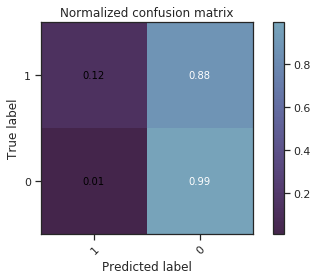

In [36]:
plot_confusion_matrix(y_test, y_predict, [1,0], normalize=True, cmap=Config.get("color_map"))

In [37]:
gs_xgboost_oversampling.best_params_

{'colsample_bytree': 0.5, 'learning_rate': 0.1}

In [38]:
best_estimator = gs_xgboost_oversampling.best_estimator_

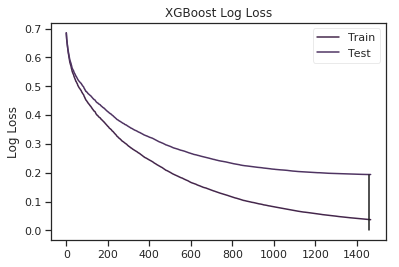

In [39]:
eval_results = gs_xgboost_oversampling.best_estimator_.evals_result()
epochs = len(eval_results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, eval_results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, eval_results['validation_1']['logloss'], label='Test')
logl_min = min(eval_results['validation_1']['logloss'])
logl_index = eval_results['validation_1']['logloss'].index(logl_min)
ax.plot((logl_index, logl_index), (0, logl_min), 'k-')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [43]:
gs_xgboost_oversampling.predict_proba(X_test_all_relevant)

array([[9.7662193e-01, 2.3378074e-02],
       [9.3878663e-01, 6.1213352e-02],
       [9.4701910e-01, 5.2980889e-02],
       ...,
       [9.9981916e-01, 1.8084883e-04],
       [7.6953644e-01, 2.3046358e-01],
       [9.9585027e-01, 4.1497401e-03]], dtype=float32)

In [42]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(y_test, gs_xgboost_oversampling.predict_proba(X_test_all_relevant)[:,1])
roc_auc = auc(y_test, y_predict)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

ValueError: x is neither increasing nor decreasing : [0 0 0 ... 0 0 0].

In [ ]:
with open(pathlib.Path(Config.get("model_store"),"gradient_boosting_boruta_oversampling.pkl"),"wb") as o:
    pickle.dump(gs_xgboost_oversampling, o)

In [ ]:
del gs_xgboot

## Train on unbalanced data

Instead of oversampling the minority class, we put weights on the minority (positive) class. XGBoost then fits using these weights.

### Setting up gridsearch

In [44]:
# Scorer, we choose ROC and set weighted average according to class frequencies
roc = make_scorer(roc_auc_score)

# Creating CV-folds respecting the class frequencies
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.get("random_seed"))

xgb_cls_weights = XGBClassifier(
        booster="gbtree",
        max_depth=6,
        scale_pos_weight=class_weight,
        n_estimators = 2000,
        colsample_by_tree=0.5,
        seed=Config.get("random_seed"),
        verbose=2)

In [47]:
gs_xgboost_class_weights = GridSearchCV(
    xgb_cls_weights,
    param_grid,
    scoring={
        "ROC_AUC": roc,
        "logloss": "neg_log_loss"
    },
    n_jobs=6,
    cv=cv,
    refit="logloss",
    verbose=3)

### Fitting and results

In [ ]:
gs_xgboost_class_weights.fit(
    X_train_all_relevant,
    y_train,
    early_stopping_rounds=10,
    eval_metric="logloss",
    eval_set=[(X_train_all_relevant, y_train), (X_test_all_relevant, y_test)])

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


In [ ]:
pd.DataFrame(gs_xgboost_class_weights.cv_results_)

In [ ]:
y_predict = gs_xgboost_class_weights.predict(X_test)

In [ ]:
print(classification_report(y_test,y_predict))

In [ ]:
plot_confusion_matrix(y_test, y_predict, [1,0], normalize=True, cmap=Config.get("color_map"))

In [ ]:
gs_xgboost_class_weights.best_estimator_

In [ ]:
eval_results = gs_xgboost_class_weights.best_estimator_.evals_result()
epochs = len(eval_results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, eval_results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, eval_results['validation_1']['logloss'], label='Test')
logl_min = min(eval_results['validation_1']['logloss'])
logl_index = eval_results['validation_1']['logloss'].index(logl_min)
ax.plot((logl_index, logl_index), (0, logl_min), 'k-')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [ ]:
with open(pathlib.Path(Config.get("model_store"),"gradient_boosting_boruta_classweights.pkl"),"wb") as of:
    pickle.dump(gs_xgboost_class_weights, of)

In [ ]:
del gs_xgboost_class_weights

##  Yet another approach
We use stumps this time

In [ ]:
# We use stochastic gradient boosting (subsample < 1),
# a maximum depth of 2 or 3,
# a very small learning rate combined with early stopping if there's no improvement
param_grid = {
    "learning_rate": [0.1, 0.3, 0.5]
}

xgb_classifier = XGBClassifier(
    booster="gbtree",
    max_depth=2,
    scale_pos_weight=scale,
    early_stopping_rounds=10,
    eval_metric=["error", "auc", "logloss"],
    n_estimators = 2000,
    subsample=0.5, # use half of features for each forest
    colsample_bytree=0.2, # use 20% of half of features for each tree in the forest
    seed=Config.get("random_seed"),
    verbose=3)

# Scorer, we choose ROC and set weighted average according to class frequencies
roc = make_scorer(roc_auc_score)

# Creating CV-folds respecting the class frequencies
cv = StratifiedShuffleSplit(n_splits=5, random_state=Config.get("random_seed"))

In [ ]:
gs_xgboost_class_weights_stumps = GridSearchCV(
    xgb_classifier,
    param_grid,
    scoring={
        "Precision": "precision",
        "ROC_AUC": roc
    },
    n_jobs=5,
    cv=cv,
    refit="ROC_AUC",
    verbose=3,
    return_train_score=True)

In [ ]:
gs_xgboost_class_weights_stumps.fit(X_train_all_relevant, y_train, eval_set=[(X_train_all_relevant, y_train), (X_test_all_relevant, y_test)])

In [ ]:
eval_results_stump = gs_xgboost_class_weights_stumps.best_estimator_.evals_result()
epochs = len(eval_results_stump['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, eval_results_stump['validation_0']['logloss'], label='Train')
ax.plot(x_axis, eval_results_stump['validation_1']['logloss'], label='Test')
logl_min = min(eval_results_stump['validation_1']['logloss'])
logl_index = eval_results_stump['validation_1']['logloss'].index(logl_min)
ax.plot((logl_index, logl_index), (0, logl_min), 'k-')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, eval_results_stump['validation_0']['error'], label='Train')
ax.plot(x_axis, eval_results_stump['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()
# plot auc
fig, ax = plt.subplots()
ax.plot(x_axis, eval_results_stump['validation_0']['auc'], label='Train')
ax.plot(x_axis, eval_results_stump['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

In [ ]:
gs_xgboost_class_weights_stumps.best_params_

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, gs_xgboost_class_weights_stumps.best_estimator_.predict_proba(X_test)[:,1],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

In [ ]:
with open(pathlib.Path(Config.get("model_store"),"gradient_boosting_boruta_stumps.pkl"),"wb") as of:
    pickle.dump(gs_xgboost_class_weights_stumps, of)

In [ ]:
del gs_xgboost_class_weights_stumps

## XGBoost with Boruta sample

In [ ]:
# We use stochastic gradient boosting (subsample < 1),
# a maximum depth of 2 or 3,
# a very small learning rate combined with early stopping if there's no improvement
param_grid = {
    "colsample_bytree": [0.1, 0.3, 0.5],
    "n_estimators": [100, 400, 800,1600]
}

xgb_classifier_fixed_size = XGBClassifier(
        booster="gbtree",
        scale_pos_weight=scale,
        max_depth=6,
        learning_rate=0.3,
        early_stopping_rounds=10,
        eval_metric=["logloss"],
        n_estimators = 400,
        subsample=0.5, # use half of features for each forest
        seed=Config.get("random_seed"),
        verbose=3)

# Scorer, we choose ROC and set weighted average according to class frequencies
roc = make_scorer(roc_auc_score)

# Creating CV-folds respecting the class frequencies
cv = StratifiedShuffleSplit(n_splits=5, random_state=Config.get("random_seed"))

In [ ]:
gs_unbalanced_xgboost_boruta = GridSearchCV(
    xgb_classifier_fixed_size,
    param_grid,
    scoring={
        "Precision": "precision",
        "ROC_AUC": roc,
        "neglogloss": "neg_log_loss"
    },
    n_jobs=5,
    cv=cv,
    refit="neglogloss",
    verbose=3,
    return_train_score=True)

In [ ]:
gs_unbalanced_xgboost_boruta.fit(X_train_all_relevant,y_train,eval_set=[(X_train_all_relevant, y_train), (X_test_all_relevant, y_test)])

In [ ]:
gs_unbalanced_xgboost_boruta.best_params_

In [ ]:
eval_results_boruta = gs_unbalanced_xgboost_boruta.best_estimator_.evals_result()
epochs = len(eval_results_boruta['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, eval_results_boruta['validation_0']['logloss'], label='Train')
ax.plot(x_axis, eval_results_boruta['validation_1']['logloss'], label='Test')
logl_min = min(eval_results_boruta['validation_1']['logloss'])
logl_index = eval_results_boruta['validation_1']['logloss'].index(logl_min)
ax.plot((logl_index, logl_index), (0, logl_min), 'k-')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [ ]:
predict = gs_unbalanced_xgboost_boruta.predict_proba(X_test_all_relevant)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, gs_unbalanced_xgboost_boruta.predict_proba(X_test_all_relevant)[:,1],pos_label=1)
roc_auc = auc(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)

In [ ]:
import xgboost
xgboost.plot_importance(gs_unbalanced_xgboost_boruta.best_estimator_.get_booster(),
                        max_num_features=20,
                        show_values=True)

In [ ]:
gs_unbalanced_xgboost_boruta.best_estimator_.feature_importances_

In [ ]:
kdd98_learn_feat_all_relevant.columns.values.tolist()[31]

In [ ]:
importances = pd.DataFrame(gs_unbalanced_xgboost_boruta.best_estimator_.feature_importances_, index=kdd98_learn_feat_all_relevant.columns.values.tolist(), columns=["importance"])

In [ ]:
importances = importances.sort_values(by="importance", ascending=False)

In [ ]:
factor_importance = 100/importances.iloc[0,0]
factor_importance

In [ ]:
importances.importance = importances.importance.map(lambda i: i*factor_importance)

In [ ]:
most_important = importances.head(50)
most_important

In [ ]:
import seaborn as sns

In [ ]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(y=most_important.index, x=most_important.importance)
sns.despine(left=True, bottom=True)